## Exploring Customer Segmentation

In this activity, you are tasked with profiling customer groups for a large telecommunications company.  The data provided contains information on customers purchasing and useage behavior with the telecom products.  Your goal is to use PCA and clustering to segment these customers into meaningful groups, and report back your findings.  

Because these results need to be interpretable, it is important to keep the number of clusters reasonable.  Think about how you might represent some of the non-numeric features so that they can be included in your segmentation models.  You are to report back your approach and findings to the class.  Be specific about what features were used and how you interpret the resulting clusters.

## Imports

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import sklearn.cluster as cluster
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors
import itertools
import warnings

In [33]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

## Data Load and Initial Display

In [3]:
df_in = pd.read_csv("./data/telco_churn_data.csv")

In [4]:
df_in.head()

,Customer ID,Referred a Friend,Number of Referrals,Tenure in Months,Offer,Phone Service,Avg Monthly Long Distance Charges,Multiple Lines,Internet Service,Internet Type,Avg Monthly GB Download,Online Security,Online Backup,Device Protection Plan,Premium Tech Support,Streaming TV,Streaming Movies,Streaming Music,Unlimited Data,Contract,Paperless Billing,Payment Method,Monthly Charge,Total Regular Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Gender,Age,Under 30,Senior Citizen,Married,Dependents,Number of Dependents,City,Zip Code,Latitude,Longitude,Population,Churn Value,CLTV,Churn Category,Churn Reason,Total Customer Svc Requests,Product/Service Issues Reported,Customer Satisfaction
0,8779-QRDMV,No,0,1,NaN,No,0.00,No,Yes,Fiber Optic,9,No,No,Yes,No,No,Yes,No,No,Month-to-Month,Yes,Bank Withdrawal,41.236,39.65,0.00,0.0,0.00,Male,78,No,Yes,No,No,0,Los Angeles,90022,34.023810,-118.156582,68701,1,5433,Competitor,Competitor offered more data,5,0,NaN
1,7495-OOKFY,Yes,1,8,Offer E,Yes,48.85,Yes,Yes,Cable,19,No,Yes,No,No,No,No,No,No,Month-to-Month,Yes,Credit Card,83.876,633.30,0.00,120.0,390.80,Female,74,No,Yes,Yes,Yes,1,Los Angeles,90063,34.044271,-118.185237,55668,1,5302,Competitor,Competitor made better offer,5,0,NaN
2,1658-BYGOY,No,0,18,Offer D,Yes,11.33,Yes,Yes,Fiber Optic,57,No,No,No,No,Yes,Yes,Yes,Yes,Month-to-Month,Yes,Bank Withdrawal,99.268,1752.55,45.61,0.0,203.94,Male,71,No,Yes,No,Yes,3,Los Angeles,90065,34.108833,-118.229715,47534,1,3179,Competitor,Competitor made better offer,1,0,NaN
3,4598-XLKNJ,Yes,1,25,Offer C,Yes,19.76,No,Yes,Fiber Optic,13,No,Yes,Yes,No,Yes,Yes,No,No,Month-to-Month,Yes,Bank Withdrawal,102.440,2514.50,13.43,327.0,494.00,Female,78,No,Yes,Yes,Yes,1,Inglewood,90303,33.936291,-118.332639,27778,1,5337,Dissatisfaction,Limited range of services,1,1,2.0
4,4846-WHAFZ,Yes,1,37,Offer C,Yes,6.33,Yes,Yes,Cable,15,No,No,No,No,No,No,No,No,Month-to-Month,Yes,Bank Withdrawal,79.560,2868.15,0.00,430.0,234.21,Female,80,No,Yes,Yes,Yes,1,Whittier,90602,33.972119,-118.020188,26265,1,2793,Price,Extra data charges,1,0,2.0


In [5]:
df_in.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 46 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Referred a Friend                  7043 non-null   object 
 2   Number of Referrals                7043 non-null   int64  
 3   Tenure in Months                   7043 non-null   int64  
 4   Offer                              3166 non-null   object 
 5   Phone Service                      7043 non-null   object 
 6   Avg Monthly Long Distance Charges  7043 non-null   float64
 7   Multiple Lines                     7043 non-null   object 
 8   Internet Service                   7043 non-null   object 
 9   Internet Type                      5517 non-null   object 
 10  Avg Monthly GB Download            7043 non-null   int64  
 11  Online Security                    7043 non-null   objec

In [6]:
df_in.describe()

,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge,Total Regular Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Age,Number of Dependents,Zip Code,Latitude,Longitude,Population,Churn Value,CLTV,Total Customer Svc Requests,Product/Service Issues Reported,Customer Satisfaction
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,1834.000000
mean,1.951867,32.386767,22.958954,21.110890,65.538800,2280.381264,1.962182,278.499225,749.099262,46.509726,0.468692,93486.070567,36.197455,-119.756684,22139.603294,0.265370,4400.295755,1.338776,0.308107,3.005453
std,3.001199,24.542061,15.448113,20.948471,30.606805,2266.220462,7.902614,685.039625,846.660055,16.750352,0.962802,1856.767505,2.468929,2.154425,21152.392837,0.441561,1183.057152,1.430471,0.717514,1.256938
min,0.000000,1.000000,0.000000,0.000000,18.250000,18.800000,0.000000,0.000000,0.000000,19.000000,0.000000,90001.000000,32.555828,-124.301372,11.000000,0.000000,2003.000000,0.000000,0.000000,1.000000
25%,0.000000,9.000000,9.210000,3.000000,35.890000,400.150000,0.000000,0.000000,70.545000,32.000000,0.000000,92101.000000,33.990646,-121.788090,2344.000000,0.000000,3469.000000,0.000000,0.000000,2.000000
50%,0.000000,29.000000,22.890000,17.000000,71.968000,1394.550000,0.000000,0.000000,401.440000,46.000000,0.000000,93518.000000,36.205465,-119.595293,17554.000000,0.000000,4527.000000,1.000000,0.000000,3.000000
75%,3.000000,55.000000,36.395000,28.000000,90.650000,3786.600000,0.000000,182.620000,1191.100000,60.000000,0.000000,95329.000000,38.161321,-117.969795,36125.000000,1.000000,5380.500000,2.000000,0.000000,4.000000
max,11.000000,72.000000,49.990000,94.000000,123.084000,8684.800000,49.790000,6477.000000,3564.720000,80.000000,9.000000,96150.000000,41.962127,-114.192901,105285.000000,1.000000,6500.000000,9.000000,6.000000,5.000000


## Cleanup

### Identify Columns with Many Nulls

If a column is at least 10% null, toss it. 10% is not magic, just convenient to toss columns with lots of nulls

In [7]:
many_nulls_columns = df_in.loc[
    :, df_in.isnull().sum() / df_in.isnull().count() * 100.0 > 10.0
].columns.to_list()

In [8]:
display(many_nulls_columns)

['Offer',
 'Internet Type',
 'Churn Category',
 'Churn Reason',
 'Customer Satisfaction']

### Perform the Cleanup

In [9]:
def cat_str_to_idx(series: pd.Series) -> pd.Series:
    """
    Map a categorical string to its index, e.g.
    [dog, cat, mouse, cat] -> [1, 0, 2, 0]
    Operates only on string types with 5 or fewer unique values
    """
    if series.dtype == "object" and series.nunique() <= 5:
        return pd.Series(np.unique(series, return_inverse=True)[1])
    return series


redundant_columns = [
    "Under 30",
    "Senior Citizen",
    "Dependents",
    "City",
    "Latitude",
    "Longitude",
]
df = df_in.drop(
    columns=many_nulls_columns + redundant_columns
)  # .apply(cat_str_to_idx)
assert np.all(df.isnull().sum() == 0), "Some Nulls Remain"
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 35 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Referred a Friend                  7043 non-null   object 
 2   Number of Referrals                7043 non-null   int64  
 3   Tenure in Months                   7043 non-null   int64  
 4   Phone Service                      7043 non-null   object 
 5   Avg Monthly Long Distance Charges  7043 non-null   float64
 6   Multiple Lines                     7043 non-null   object 
 7   Internet Service                   7043 non-null   object 
 8   Avg Monthly GB Download            7043 non-null   int64  
 9   Online Security                    7043 non-null   object 
 10  Online Backup                      7043 non-null   object 
 11  Device Protection Plan             7043 non-null   objec

,Customer ID,Referred a Friend,Number of Referrals,Tenure in Months,Phone Service,Avg Monthly Long Distance Charges,Multiple Lines,Internet Service,Avg Monthly GB Download,Online Security,Online Backup,Device Protection Plan,Premium Tech Support,Streaming TV,Streaming Movies,Streaming Music,Unlimited Data,Contract,Paperless Billing,Payment Method,Monthly Charge,Total Regular Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Gender,Age,Married,Number of Dependents,Zip Code,Population,Churn Value,CLTV,Total Customer Svc Requests,Product/Service Issues Reported
0,8779-QRDMV,No,0,1,No,0.00,No,Yes,9,No,No,Yes,No,No,Yes,No,No,Month-to-Month,Yes,Bank Withdrawal,41.236,39.65,0.00,0.0,0.00,Male,78,No,0,90022,68701,1,5433,5,0
1,7495-OOKFY,Yes,1,8,Yes,48.85,Yes,Yes,19,No,Yes,No,No,No,No,No,No,Month-to-Month,Yes,Credit Card,83.876,633.30,0.00,120.0,390.80,Female,74,Yes,1,90063,55668,1,5302,5,0
2,1658-BYGOY,No,0,18,Yes,11.33,Yes,Yes,57,No,No,No,No,Yes,Yes,Yes,Yes,Month-to-Month,Yes,Bank Withdrawal,99.268,1752.55,45.61,0.0,203.94,Male,71,No,3,90065,47534,1,3179,1,0
3,4598-XLKNJ,Yes,1,25,Yes,19.76,No,Yes,13,No,Yes,Yes,No,Yes,Yes,No,No,Month-to-Month,Yes,Bank Withdrawal,102.440,2514.50,13.43,327.0,494.00,Female,78,Yes,1,90303,27778,1,5337,1,1
4,4846-WHAFZ,Yes,1,37,Yes,6.33,Yes,Yes,15,No,No,No,No,No,No,No,No,Month-to-Month,Yes,Bank Withdrawal,79.560,2868.15,0.00,430.0,234.21,Female,80,Yes,1,90602,26265,1,2793,1,0


## PCA

### Select Numeric Columns

Those columns where data type is not object

In [102]:
df_numeric = df[df.columns[df.dtypes != "object"]]
df_numeric.head()
df_numeric.shape

(7043, 17)

### Scale

In [103]:
df_scaled = (df_numeric - df_numeric.mean()) / df_numeric.std()
df_scaled.head()

,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge,Total Regular Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Age,Number of Dependents,Zip Code,Population,Churn Value,CLTV,Total Customer Svc Requests,Product/Service Issues Reported
0,-0.650362,-1.278897,-1.486198,-0.578128,-0.794033,-0.988753,-0.248295,-0.406545,-0.884770,1.879977,-0.486800,-1.865646,2.201235,1.66371,0.872912,2.559453,-0.429410
1,-0.317162,-0.993672,1.676001,-0.100766,0.599122,-0.726797,-0.248295,-0.231372,-0.423191,1.641176,0.551835,-1.843564,1.585088,1.66371,0.762181,2.559453,-0.429410
2,-0.650362,-0.586209,-0.752775,1.713209,1.102016,-0.232913,5.523212,-0.406545,-0.643894,1.462075,2.629105,-1.842487,1.200545,1.66371,-1.032322,-0.236828,-0.429410
3,-0.317162,-0.300984,-0.207077,-0.387183,1.205653,0.103308,1.451142,0.070800,-0.301301,1.879977,0.551835,-1.714308,0.266561,1.66371,0.791766,-0.236828,0.964292
4,-0.317162,0.187973,-1.076439,-0.291711,0.458107,0.259361,-0.248295,0.221156,-0.608142,1.999377,0.551835,-1.553275,0.195032,1.66371,-1.358595,-0.236828,-0.429410


### Cumulative EV vs. Num Components

#### Looking for Combinations with High Cumulative EV With 3 Components

In [95]:
inds = list(range(df_numeric.shape[1]))
choosek = 5
combos = list(itertools.combinations(inds, choosek))
cum_ev_3_comp = []

for m in range(len(combos)):
    combo = list(combos[m])
    df_scaled_mk = df_scaled.iloc[:, combo]
    cum_ev = (
        PCA(n_components=choosek, random_state=123)
        .fit(df_scaled_mk)
        .explained_variance_ratio_
        * 100.0
    ).cumsum()

    ncomp = 3
    cum_ev_3_comp.append(cum_ev[ncomp - 1])
    if m % 1000 == 0:
        display([m, combo, cum_ev_3_comp[-1]])

[0, [0, 1, 2, 3, 4], 75.63737987613123]

[1000, [0, 3, 7, 10, 11], 73.7169853014943]

[2000, [1, 2, 5, 10, 13], 82.23365216815537]

[3000, [1, 7, 8, 14, 15], 79.84924569733589]

[4000, [2, 7, 8, 13, 16], 81.33908558406193]

[5000, [4, 5, 8, 12, 13], 85.02030742553312]

[6000, [7, 9, 10, 12, 16], 65.34429167434476]

[1900,
 96.54480939989142,
 Index(['Tenure in Months', 'Avg Monthly Long Distance Charges',
        'Monthly Charge', 'Total Regular Charges',
        'Total Long Distance Charges'],
       dtype='object')]

[1834,
 94.26801706353645,
 Index(['Tenure in Months', 'Avg Monthly Long Distance Charges',
        'Avg Monthly GB Download', 'Total Regular Charges',
        'Total Long Distance Charges'],
       dtype='object')]

[1987,
 94.09984000709757,
 Index(['Tenure in Months', 'Avg Monthly Long Distance Charges',
        'Total Regular Charges', 'Total Long Distance Charges', 'Churn Value'],
       dtype='object')]

[1974,
 94.0752097389918,
 Index(['Tenure in Months', 'Avg Monthly Long Distance Charges',
        'Total Regular Charges', 'Total Extra Data Charges',
        'Total Long Distance Charges'],
       dtype='object')]

[1984,
 93.88736334740159,
 Index(['Tenure in Months', 'Avg Monthly Long Distance Charges',
        'Total Regular Charges', 'Total Long Distance Charges',
        'Number of Dependents'],
       dtype='object')]

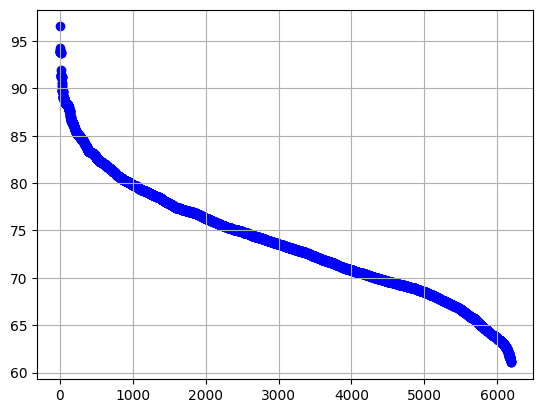

In [105]:
sorted_inds = np.argsort(cum_ev_3_comp)[::-1]
plt.scatter(range(len(combos)), np.array(cum_ev_3_comp)[sorted_inds], color="blue")
plt.grid()

for ind in range(5):
    m = sorted_inds[ind]
    combo = list(combos[m])
    combo_columns = df_scaled.columns[combo]
    display([m, cum_ev_3_comp[m], combo_columns])

In [107]:
df_scaled = df_scaled.iloc[:, list(combos[sorted_inds[0]])]

#### Cumulative EV

In [108]:
ev = (
    PCA(n_components=df_scaled.shape[1], random_state=123)
    .fit(df_scaled)
    .explained_variance_ratio_
    * 100.0
)
cum_ev = ev.cumsum()

#### Plot

[None, None, None, None]

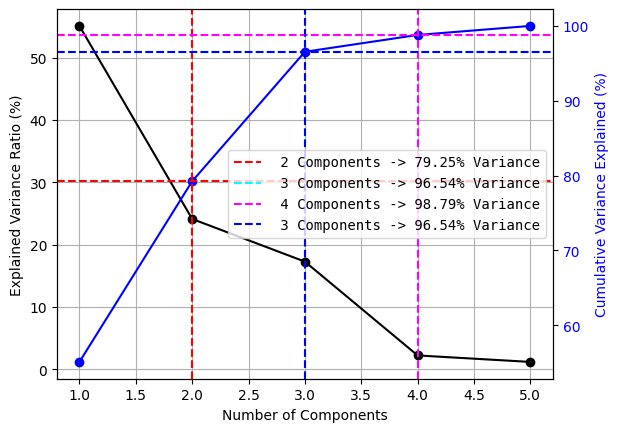

In [109]:
fig, ax1 = plt.subplots()

ax1_color = "black"
ax1.plot(
    np.arange(len(ev)) + 1,
    ev,
    linestyle="solid",
    marker="o",
    color=ax1_color,
)

ax1.grid(True)
ax1.set_xlabel("Number of Components")
ax1.set_ylabel("Explained Variance Ratio (%)", color=ax1_color)

ax2_color = "blue"
ax2 = ax1.twinx()
ax2.plot(
    np.arange(len(cum_ev)) + 1,
    cum_ev,
    linestyle="solid",
    marker="o",
    color=ax2_color,
)

ax2.set_ylabel("Cumulative Variance Explained (%)", color=ax2_color)
ax2.tick_params(axis="y", labelcolor=ax2_color)


def crosshairs_at(
    target_cev: float = 0.0, ncomp: int = None, color: str = "", linestyle: str = "--"
):
    if ncomp is None:
        ncomp = PCA(n_components=target_cev / 100.0).fit(df_scaled).n_components_

    label = "%2d Components -> %.2f%% Variance" % (ncomp, cum_ev[ncomp - 1])
    ax2.axhline(cum_ev[ncomp - 1], color=color, linestyle=linestyle)
    ax2.axvline(ncomp, label=label, color=color, linestyle=linestyle)


crosshairs_at(ncomp=2, color="red")
crosshairs_at(ncomp=3, color="cyan")
crosshairs_at(ncomp=4, color="magenta")
crosshairs_at(target_cev=95.0, color="blue")

plt.setp(plt.legend(loc="center right", fancybox=True).texts, family="monospace")

### Fit

For simplicity just go with 3 components for PCA

In [110]:
X = PCA(n_components=3, random_state=123).fit_transform(df_scaled)

## Clustering with KMeans

### Parameter Search

#### Search Over Number of Clusters

In [111]:
n_clusters_list = np.arange(2, 8)
display(n_clusters_list)
inertia = []

for n_clusters in n_clusters_list:
    kmeans = cluster.KMeans(n_clusters=n_clusters, random_state=123).fit(X)
    (_, counts) = np.unique(kmeans.labels_, return_counts=True)
    display([n_clusters, kmeans.inertia_, counts])
    inertia.append(kmeans.inertia_)

array([2, 3, 4, 5, 6, 7])

[2, 19794.863683184543, array([2506, 4537])]

[3, 16067.8028041047, array([2205, 2437, 2401])]

[4, 12569.19160002513, array([1267, 2176, 2172, 1428])]

[5, 10029.559718496868, array([1229, 2081, 1770, 1148,  815])]

[6, 8727.577644138173, array([1123, 1768,  893, 1109,  636, 1514])]

[7, 7631.2921171583375, array([ 780, 1223, 1195,  876,  560, 1389, 1020])]

#### Plot Inertia vs. Num Clusters

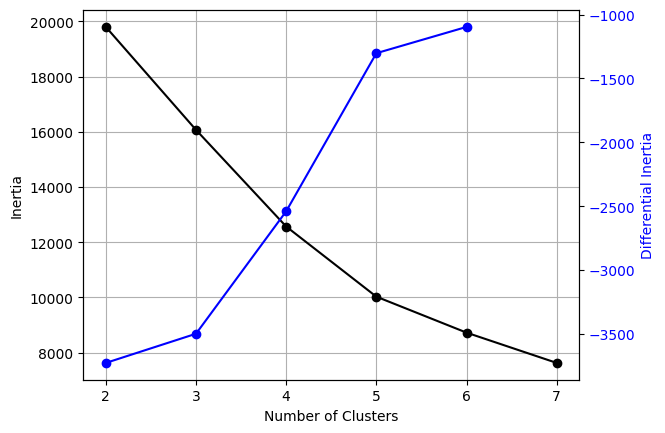

In [112]:
fig, ax1 = plt.subplots()

# Inertia vs. Num Clusters
ax1_color = "black"
ax1.plot(
    n_clusters_list,
    inertia,
    linestyle="solid",
    marker="o",
    color=ax1_color,
)

ax1.set_xlabel("Number of Clusters")
ax1.set_ylabel("Inertia")
ax1.grid()

# Differential Inertia vs. Num Clusters
ax2_color = "blue"
ax2 = ax1.twinx()
ax2.plot(
    n_clusters_list[:-1],
    np.diff(inertia),
    linestyle="solid",
    marker="o",
    color=ax2_color,
)

ax2.set_ylabel("Differential Inertia", color=ax2_color)
ax2.tick_params(axis="y", labelcolor=ax2_color)

#### Conclusion

5 clusters is good enough, after that the improvement decelerates

### Cluster

In [113]:
kmeans = cluster.KMeans(n_clusters=5, random_state=123).fit(X)

(unique_labels, counts) = np.unique(kmeans.labels_, return_counts=True)
display([unique_labels, counts, kmeans.inertia_])

[array([0, 1, 2, 3, 4], dtype=int32),
 array([1229, 2081, 1770, 1148,  815]),
 10029.55971849687]

### Label Data

In [115]:
df_labeled = pd.DataFrame(
    X, columns=["Component" + str(k + 1) for k in range(X.shape[1])]
).join(pd.DataFrame({"kmeans": kmeans.labels_}))
df_labeled.head()

,Component1,Component2,Component3,kmeans
0,-2.266215,0.727122,0.211305,2
1,-0.524942,-1.496994,-1.427765,1
2,-0.537047,0.911794,-1.140786,1
3,0.129731,0.540392,-1.148937,1
4,-0.157266,1.332109,-0.180715,0


In [127]:
df_labeled.groupby("kmeans").count()

,Component1,Component2,Component3,dbscan
kmeans,,,,
0,1229,1229,1229,1229
1,2081,2081,2081,2081
2,1770,1770,1770,1770
3,1148,1148,1148,1148
4,815,815,815,815


### Scatter Plot

In [116]:
fig = px.scatter_3d(
    data_frame=df_labeled,
    x="Component1",
    y="Component2",
    z="Component3",
    color="kmeans",
)

fig.update_layout(autosize=False, width=1200, height=800)
fig.show()

## Clustering with DBSCAN

### Parameter Search

Search over range of eps and min samples

#### K-Distance Graph

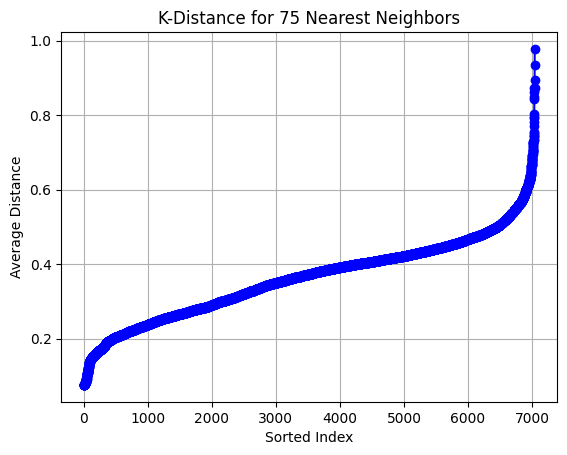

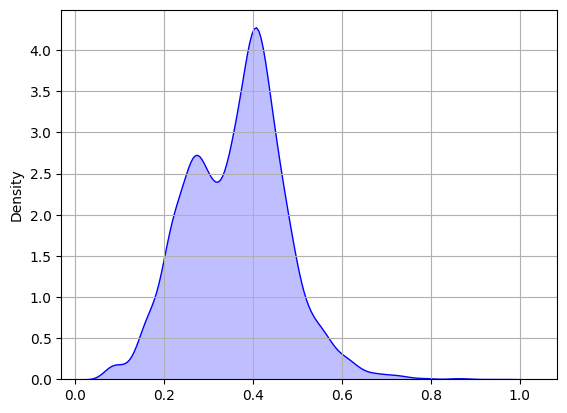

In [134]:
min_samples = 75
distances = np.sort(
    np.mean(
        NearestNeighbors(n_neighbors=min_samples, algorithm="auto")
        .fit(X)
        .kneighbors(X)[0],
        axis=1,
    )
)

fig, ax = plt.subplots()
ax.plot(
    distances,
    linestyle="solid",
    marker="o",
    color="blue",
)

ax.set_xlabel("Sorted Index")
ax.set_ylabel("Average Distance")
ax.grid()
plt.title("K-Distance for %d Nearest Neighbors" % min_samples)

plt.figure()
sns.kdeplot(distances, shade=True, color="blue")
plt.grid()

#### Perform the Search

In [133]:
eps_start = 0.5
eps_stop = 0.7
num_eps_points = 21
eps_list = np.linspace(eps_start, eps_stop, num_eps_points, endpoint=True)
display(eps_list)

n_clusters_list = []
n_noise_list = []

for eps in eps_list:
    dbscan = cluster.DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    n_clusters_list.append(len(np.unique(dbscan.labels_[dbscan.labels_ != -1])))
    n_noise_list.append(np.sum(dbscan.labels_ == -1))

# for eps in eps_list:
#     for min_samples in min_samples_list:
#         dbscan = cluster.DBSCAN(eps=eps, min_samples=min_samples).fit(X)
#         (unique_labels, counts) = np.unique(dbscan.labels_, return_counts=True)
#         null_count = counts[unique_labels == -1][0] if -1 in unique_labels else 0
#         null_pct = null_count / len(X) * 100.0
#         non_null_pct = counts[unique_labels != -1] / len(X) * 100.0
#         num_labels = np.sum(unique_labels != -1)
#         if num_labels in [2, 3, 4, 5] and null_pct < 25.0 or 1:
#             score = 0.0  # metrics.silhouette_score(X, dbscan.labels_)
#             msg = (
#                 "eps = %.2f, min samples = %d, nulls = %d, %.2f%%, num labels = %d, score = %.2f, label distr = %s"
#                 % (
#                     eps,
#                     min_samples,
#                     null_count,
#                     null_pct,
#                     num_labels,
#                     score,
#                     str(np.round(non_null_pct, 1)),
#                 )
#             )
#             print(msg)

array([0.5 , 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 ,
       0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7 ])

### Plot Search Results

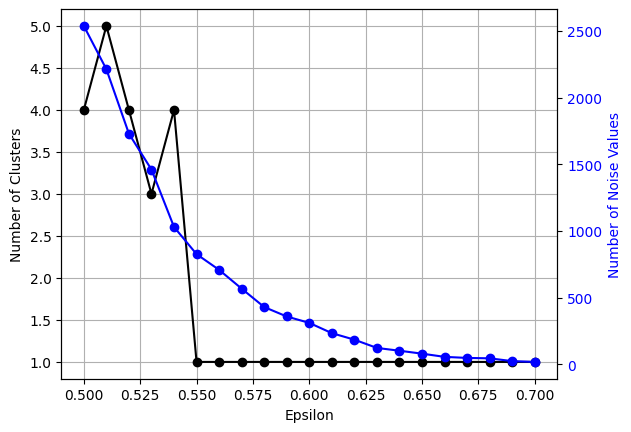

In [135]:
fig, ax1 = plt.subplots()

ax1_color = "black"
ax1.plot(
    eps_list,
    n_clusters_list,
    linestyle="solid",
    marker="o",
    color=ax1_color,
)

ax1.set_xlabel("Epsilon")
ax1.set_ylabel("Number of Clusters")
ax1.grid()

ax2_color = "blue"
ax2 = ax1.twinx()
ax2.plot(
    eps_list,
    n_noise_list,
    linestyle="solid",
    marker="o",
    color=ax2_color,
)

ax2.set_ylabel("Number of Noise Values", color=ax2_color)
ax2.tick_params(axis="y", labelcolor=ax2_color)

### Cluster

In [136]:
dbscan = cluster.DBSCAN(eps=0.54, min_samples=min_samples).fit(X)
(unique_labels, counts) = np.unique(dbscan.labels_, return_counts=True)
display([unique_labels, counts])

[array([-1,  0,  1,  2,  3]), array([1030, 4981,  943,   32,   57])]

### Label Data

In [137]:
df_labeled["dbscan"] = dbscan.labels_

### Scatter Plot

In [139]:
fig = px.scatter_3d(
    data_frame=df_labeled.query("dbscan > -1"),
    x="Component1",
    y="Component2",
    z="Component3",
    color="dbscan",
)

fig.update_layout(autosize=False, width=1200, height=800)
fig.show()

## Clustering with OPTICS

In [25]:
# optics = cluster.OPTICS(min_samples=10).fit(X)
# (unique_labels, counts) = np.unique(optics.labels_, return_counts=True)
# display([unique_labels, counts])
# optics.get_params(deep=True)